In [55]:
import torch
import torchvision
import sklearn.metrics as metrics
import numpy as np
import sys
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# COMP9444 Assignment 2

## Cat breed classification

## Neural Network

**student.py**

UNSW COMP9444 Neural Networks and Deep Learning

You may modify this file however you wish, including creating additional
variables, functions, classes, etc., so long as your code runs with the
hw2main.py file unmodified, and you are only using the approved packages.

You have been given some default values for the variables train_val_split,
batch_size as well as the transform function.
You are encouraged to modify these to improve the performance of your model.

**Answer to Question:**

Briefly describe how your program works, and explain any design and training
decisions you made along the way.

In [56]:
#                 transforms.ColorJitter(brightness=0.5),

############################################################################
######     Specify transform(s) to be applied to the input images     ######
############################################################################

# def transform(mode):
#     """
#     Called when loading the data. Visit this URL for more information:
#     https://pytorch.org/vision/stable/transforms.html
#     You may specify different transforms for training and testing
#     """
#     if mode == 'train':
#         return transforms.Compose(
#             [
#                 transforms.RandomHorizontalFlip(),
#                 transforms.CenterCrop(60),
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=[0.4817, 0.4347, 0.3928], std=[0.2483, 0.2402, 0.2335])
#             ]
#         )
#     elif mode == 'test':
#         return transforms.Compose(
#             [   
#                 transforms.RandomHorizontalFlip(),
#                 transforms.CenterCrop(60),
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=[0.4817, 0.4347, 0.3928], std=[0.2483, 0.2402, 0.2335])
#             ]
#         )


# trying greyscale
# def transform(mode):
#     """
#     Called when loading the data. Visit this URL for more information:
#     https://pytorch.org/vision/stable/transforms.html
#     You may specify different transforms for training and testing
#     """
#     if mode == 'train':
#         return transforms.Compose(
#             [
#                 transforms.RandomHorizontalFlip(),
#                 transforms.Grayscale(),
#                 torchvision.transforms.CenterCrop(60),
#                 transforms.ToTensor()
#             ]
#         )
#     elif mode == 'test':
#         return transforms.Compose(
#             [   
#                 transforms.RandomHorizontalFlip(),
#                 transforms.Grayscale(),
#                 torchvision.transforms.CenterCrop(60),
#                 transforms.ToTensor()
#             ]
#         )

# def transform(mode):
#     """
#     Called when loading the data. Visit this URL for more information:
#     https://pytorch.org/vision/stable/transforms.html
#     You may specify different transforms for training and testing
#     """
#     if mode == 'train':
#         return transforms.Compose(
#             [
#                 transforms.RandomHorizontalFlip(),
#                 transforms.Grayscale(),
#                 torchvision.transforms.CenterCrop(60),
#                 transforms.ToTensor()
#             ]
#         )
#     elif mode == 'test':
#         return transforms.Compose(
#             [   
#                 transforms.RandomHorizontalFlip(),
#                 transforms.Grayscale(),
#                 torchvision.transforms.CenterCrop(60),
#                 transforms.ToTensor()
#             ]
#         )

def transform(mode):
    """
    Called when loading the data. Visit this URL for more information:
    https://pytorch.org/vision/stable/transforms.html
    You may specify different transforms for training and testing
    """

    # channel size = 3

    if mode == 'train':
        return transforms.Compose(
            [   
                transforms.RandomCrop((64, 64)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation((-10,10)),
                transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.3, hue=0.2),
                transforms.RandomPosterize(bits=3, p=0.4),
                transforms.RandomEqualize(p=0.1),
                transforms.RandomGrayscale(p=0.1),
                transforms.RandomPerspective(distortion_scale=0.05, p=0.1, fill=0),
                ## T.RandomErasing(),
                ## T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                ## T.RandomInvert(p=0.05),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
    elif mode == 'test':
        return transforms.Compose(
            [   
                transforms.CenterCrop((64, 64)),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## transforms.Normalize([0.485, 0.456, 0.406],
                ##                                 [0.229, 0.224, 0.225]),
            ]
        )

In [57]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 30, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(30, 120, kernel_size=3)
        self.conv3 = nn.Conv2d(120, 360, kernel_size=3)
        self.conv4 = nn.Conv2d(360, 540, kernel_size=3)
        self.fc1 = nn.Linear(540*2*2, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 8) # output layer
        # Dropout
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        ###############
        # CONV Layers #
        ###############
        out = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        out = F.max_pool2d(F.relu(self.conv2(out)), (2, 2))
        out = F.max_pool2d(F.relu(self.conv3(out)), (2, 2))
        out = F.max_pool2d(F.relu(self.conv4(out)), (2, 2))
        #print(out.shape)
        out = out.view(out.size(0), -1)
        
        ##########################
        # Fully Connected Layers #
        ##########################
        out = self.dropout(F.relu(self.fc1(out)))
        out = self.dropout(F.relu(self.fc2(out)))
        
        ################
        # Output Layer #
        ################
        predicted_output = F.log_softmax(self.fc3(out), dim=1)
        return predicted_output

    
class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 30, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(30, 120, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(120, 360, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(360, 540, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(540*3*3, 1000),
            nn.ReLU(),
            
            nn.Dropout(p=0.4),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            
            nn.Dropout(p=0.4),
            nn.Linear(1000, 8)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)    
    
    
net = Network()
############################################################################
######      Specify the optimizer and loss function                   ######
############################################################################
learning_rate = 0.001
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# loss_func = F.nll_loss
loss_func = nn.CrossEntropyLoss()

############################################################################
######  Custom weight initialization and lr scheduling are optional   ######
############################################################################

# Normally, the default weight initialization and fixed learing rate
# should work fine. But, we have made it possible for you to define
# your own custom weight initialization and lr scheduler, if you wish.
def weights_init(m):
    return

scheduler = None


In [58]:
############################################################################
#######              Metaparameters and training options              ######
############################################################################
dataset = "./data"
train_val_split = 0.8
batch_size = 200
epochs = 60

## HW 2 Main

In [59]:
# Use a GPU if available, as it should be faster.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
    
# Test network on validation set, if it exists.
def test_network(net,testloader,print_confusion=False):
    net.eval()
    total_images = 0
    total_correct = 0
    conf_matrix = np.zeros((8,8))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                labels.cpu(),predicted.cpu(),labels=[0,1,2,3,4,5,6,7])

    model_accuracy = total_correct / total_images * 100
    print(', {0} test {1:.2f}%'.format(total_images,model_accuracy))
    if print_confusion:
        np.set_printoptions(precision=2, suppress=True)
        print(conf_matrix)
    net.train()

Using device: cuda:0

test data distribution - {0: 808, 1: 798, 2: 839, 3: 804, 4: 795, 5: 774, 6: 783, 7: 799}
first item in last batch, label 3 - Russian Blue


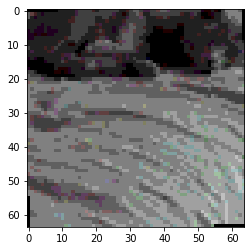

second item in last batch, label 3 - Russian Blue


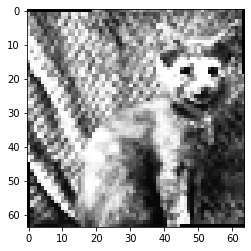

last item in last batch, label 6 - Tortoiseshell


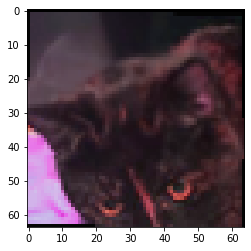

torch.Size([3, 64, 64])
Network(
  (conv1): Conv2d(3, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(30, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(120, 360, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(360, 540, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2160, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=8, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
Start training...
ep 1, loss: 63.80, 6400 train 19.50%, 1600 test 21.00%
ep 2, loss: 60.64, 6400 train 23.38%, 1600 test 26.75%
ep 3, loss: 58.29, 6400 train 27.47%, 1600 test 29.38%
ep 4, loss: 56.97, 6400 train 30.05%, 1600 test 32.50%
ep 5, loss: 55.72, 6400 train 32.47%, 1600 test 31.00%
ep 6, loss: 53.67, 6400 train 35.52%, 1600 test 39.75%
ep 7, loss: 52.74, 6400 train 37.02%, 1600 test 37.62%
ep 8, loss: 51.30, 6400 train 39.62%, 1600 test 46.25%
ep 9, loss:

In [ ]:
# Cat breed dictionary 
cat_dict = {
    0: 'Bombay',
    1: 'Calico',
    2: 'Persian',
    3: 'Russian Blue',
    4: 'Siamese',
    5: 'Tiger',
    6: 'Tortoiseshell',
    7: 'Tuxedo'
}

# Main
print("Using device: {}"
      "\n".format(str(device)))
########################################################################
#######                      Loading Data                        #######
########################################################################
data = torchvision.datasets.ImageFolder(root=dataset)

if train_val_split == 1:
    # Train on the entire dataset
    data = torchvision.datasets.ImageFolder(root=dataset,
                        transform=transform('train'))
    trainloader = torch.utils.data.DataLoader(data,
                        batch_size=batch_size, shuffle=True);
else:
    # Split the dataset into trainset and testset
    data = torchvision.datasets.ImageFolder(root=dataset)
    data.len=len(data)
    train_len = int((train_val_split)*data.len)
    test_len = data.len - train_len
    train_subset, test_subset = random_split(data, [train_len, test_len])
    trainset = DatasetFromSubset(
        train_subset, transform=transform('train'))
    testset = DatasetFromSubset(
        test_subset, transform=transform('test'))

    trainloader = torch.utils.data.DataLoader(trainset, 
                        batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, 
                        batch_size=batch_size, shuffle=False)

#########################
#**     REMOVABLE     **#
#########################
# Getting count of each cat breed, should be close to 0.8*1000 each--
total = 0
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
for data in trainloader:
    Xs, ys = data
    for y in ys:
        counter_dict[(int(y))] += 1
        total += 1
print(f'test data distribution - {counter_dict}')
# print(Xs) # last batch in our iteration size = 200 by default
# print(ys) # last batch (labels) in our iteration size = 200 by default
# https://stackoverflow.com/questions/53623472/how-do-i-display-a-single-image-in-pytorch/53633017
print(f'first item in last batch, label {ys[0]} - {cat_dict[ys.numpy()[0]]}')
plt.imshow(Xs[0].permute(1, 2, 0))
plt.show()
print(f'second item in last batch, label {ys[1]} - {cat_dict[ys.numpy()[1]]}')
plt.imshow(Xs[1].permute(1, 2, 0))
plt.show()
print(f'last item in last batch, label {ys[-1]} - {cat_dict[ys.numpy()[-1]]}')
plt.imshow(Xs[-1].permute(1, 2, 0))
plt.show()
print(Xs[0].shape)

## https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch

# from torch.utils.data import TensorDataset, DataLoader

# nimages = 0
# mean = 0.0
# var = 0.0
# for i_batch, batch_target in enumerate(trainloader):
#     batch = batch_target[0]
#     # Rearrange batch to be the shape of [B, C, W * H]
#     batch = batch.view(batch.size(0), batch.size(1), -1)
#     # Update total number of images
#     nimages += batch.size(0)
#     # Compute mean and std here
#     mean += batch.mean(2).sum(0) 
#     var += batch.var(2).sum(0)

# mean /= nimages
# var /= nimages
# std = torch.sqrt(var)

# print('mean')
# print(mean)
# print('std')
# print(std)

#############################
#**     REMOVABLE END     **#
#############################

# Get model, loss criterion and optimizer from student
net = net.to(device)
print(net)
criterion = loss_func
optimizer = optimizer
# get weight initialization and lr scheduler, if appropriate
weights_init = weights_init
scheduler = scheduler

# apply custom weight initialization, if it exists
net.apply(weights_init)

########################################################################
#######                        Training                          #######
########################################################################
print("Start training...")
for epoch in range(1,epochs+1):
    total_loss = 0
    total_images = 0
    total_correct = 0

    for batch in trainloader:           # Load batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = net(images)             # Process batch

        loss = criterion(preds, labels) # Calculate loss

        optimizer.zero_grad()
        loss.backward()                 # Calculate gradients
        optimizer.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_images += labels.size(0)
        total_correct += output.eq(labels).sum().item()

    # apply lr schedule, if it exists
    if scheduler is not None:
        scheduler.step()

    model_accuracy = total_correct / total_images * 100
    print('ep {0}, loss: {1:.2f}, {2} train {3:.2f}%'.format(
           epoch, total_loss, total_images, model_accuracy), end='')

    if train_val_split < 1:
        test_network(net,testloader,
                     print_confusion=(epoch % 10 == 0))
    else:
        print()

    if epoch % 10 == 0:
        torch.save(net.state_dict(),'checkModel.pth')
        print("   Model saved to checkModel.pth")        

    sys.stdout.flush()

torch.save(net.state_dict(),'savedModel.pth')
print("   Model saved to savedModel.pth")

### Analysis